<a href="https://colab.research.google.com/github/Black3rror/AI/blob/master/Playground/Deep_JSCC_for_wireless_image_transmission_papaer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

To implement the proposed model in related paper

# Importing stuff

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose

import matplotlib.pyplot as plt   # if u want to show imgs by pyplot

from tensorflow.keras.callbacks import TensorBoard
import datetime   # to organize TensorBoard files

from keras.utils import to_categorical    # to change a number to one-hot key

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/   # Clear any logs from previous runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# New layers

## ValNormalize layer

In [ ]:
class ValNormalize(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ValNormalize, self).__init__(**kwargs)
  
  def build(self, input_shape):
    pass
  
  def call(self, inputs):
    z = inputs / 255
    return z

## PowerNormalize layer

In [ ]:
class PowerNormalize(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(PowerNormalize, self).__init__(**kwargs)
  
  def build(self, input_shape):
    pass
  
  def call(self, inputs):
    k = inputs.shape[1]
    z = tf.sqrt(tf.constant(k, 'float32')) * inputs / (tf.norm(inputs)**2)
    return z

## Channel layer

In [ ]:
class Channel(keras.layers.Layer):
  def __init__(self, snr, **kwargs):
    super(Channel, self).__init__(**kwargs)
    self.noise_std = 10**(-snr/10)
  
  def build(self, input_shape):
    pass
  
  def call(self, inputs):
    k = inputs.shape[1]
    gnoise = tf.random.normal((k,), mean = 0, stddev = self.noise_std)
    return inputs + gnoise

## Denormalize layer

In [ ]:
class Denormalize(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(Denormalize, self).__init__(**kwargs)
  
  def build(self, input_shape):
    pass
  
  def call(self, inputs):
    z = tf.clip_by_value(inputs * 255, clip_value_min = 0, clip_value_max = 255)
    return z

# Initialization

In [ ]:
assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
(trainX, _), (testX, _) = keras.datasets.cifar10.load_data()   # import well known datasets

# Build the model

In [ ]:
k = 500

model = Sequential()

model.add(ValNormalize(input_shape = trainX.shape[1:]))
model.add(Conv2D(16, (5, 5), (2, 2), padding = 'same', activation = 'relu'))
model.add(Conv2D(32, (5, 5), (2, 2), padding = 'same', activation = 'relu'))
model.add(Conv2D(32, (5, 5), (1, 1), padding = 'same', activation = 'relu'))
model.add(Conv2D(32, (5, 5), (1, 1), padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(k))
model.add(PowerNormalize())

model.add(Channel(20))

model.add(Dense(32 * 8 * 8, activation = 'relu'))
model.add(Reshape((8, 8, 32)))
model.add(Conv2DTranspose(32, (5, 5), (1, 1), padding = 'same', activation = 'relu'))
model.add(Conv2DTranspose(32, (5, 5), (1, 1), padding = 'same', activation = 'relu'))
model.add(Conv2DTranspose(32, (5, 5), (2, 2), padding = 'same', activation = 'relu'))
model.add(Conv2DTranspose(16, (5, 5), (2, 2), padding = 'same', activation = 'relu'))
model.add(Conv2DTranspose(3 , (5, 5), (1, 1), padding = 'same', activation = 'sigmoid'))
model.add(Denormalize())

# Compile and fit

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=trainX, y=trainX, epochs=100, validation_data=(testX, testX), 
          callbacks=[tensorboard_callback])

Epoch 1/100
1563/1563 [==============================] - 10s 6ms/step - loss: 145.1195 - mean_absolute_error: 8.7051 - val_loss: 321.9846 - val_mean_absolute_error: 14.1378
Epoch 2/100
1563/1563 [==============================] - 10s 6ms/step - loss: 144.7433 - mean_absolute_error: 8.6960 - val_loss: 300.9587 - val_mean_absolute_error: 13.5823
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 144.0817 - mean_absolute_error: 8.6794 - val_loss: 369.5752 - val_mean_absolute_error: 15.1220
Epoch 4/100
1563/1563 [==============================] - 10s 6ms/step - loss: 143.5010 - mean_absolute_error: 8.6571 - val_loss: 249.8770 - val_mean_absolute_error: 12.3177
Epoch 5/100
1563/1563 [==============================] - 10s 6ms/step - loss: 142.4987 - mean_absolute_error: 8.6319 - val_loss: 254.6377 - val_mean_absolute_error: 12.5292
Epoch 6/100
1563/1563 [==============================] - 10s 7ms/step - loss: 141.8663 - mean_absolute_error: 8.6125 - val_loss: 209.87

In [ ]:
%tensorboard --logdir logs/fit    # to run the TensorBoard in the notebook

# Predicting

(10, 32, 32, 3)


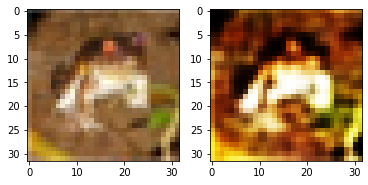

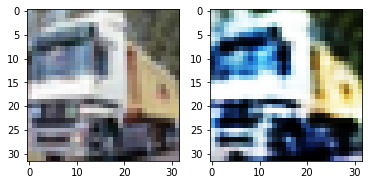

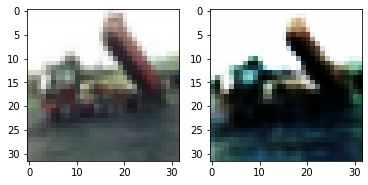

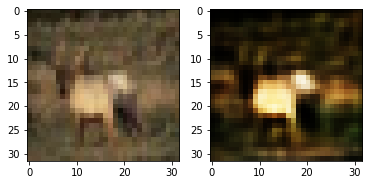

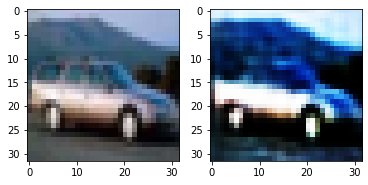

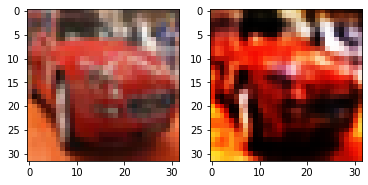

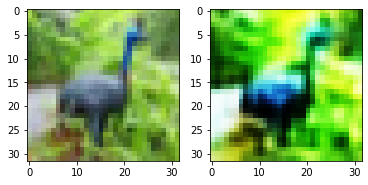

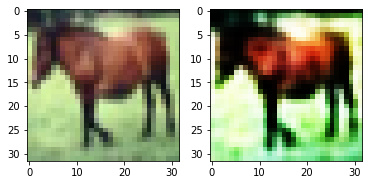

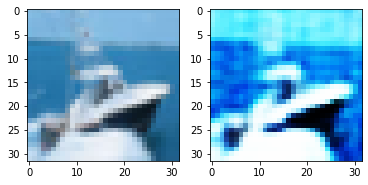

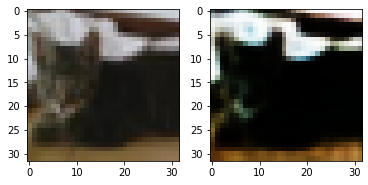

In [ ]:
predicts = model.predict(trainX[:10])
print(predicts.shape)
for i in range(len(predicts)):
  fig = plt.figure()
  fig.add_subplot(1, 2, 1)
  plt.imshow(trainX[i])
  fig.add_subplot(1, 2, 2)
  plt.imshow(predicts[i]/255)
  plt.show()

# Conclusion

We've got almost the same result (a little worse) on trainset. But we couldn't get the same result on the testset, so we may need to do regularization but its not mentioned in the paper. The only condition we checked is 
- k = 500
- SNR = 20

Also our model has one more conv layer at the output (to convert the output to the 32x32x3 shape).